### An Example of Transfer Learning for Image Classification

Transfer Learning is the re-use of pre-trained models on new tasks. Most often, the two tasks are different but somehow related to each other. For example, a model which was trained on image classification might have learnt image features which can also be harnessed for other image related tasks. This technique became increasingly popular in the field of Deep Learning since it enables one to train a model on comparatively little data.

### Table of Contents

#### 1. [Setup](#Setup)
#### 2. [Data loading and pre-processing](#Data-loading-and-pre-processing)
#### 3. [Loading a pre-trained model](#Loading-a-pre-trained-model)
#### 4. [Training the last layer](#Training-the-last-layer)

---

# Setup

In this notebook, we consider the [Alien vs Preditor](https://www.kaggle.com/pmigdal/alien-vs-predator-images) task from [Kaggle](http://www.kaggle.com). We want to classify images as either 'aliens' or 'predators'.

Because the dataset is relatively small, and we don't want to wait for hours, we use a model pre-trained on the very large ImageNet task.

![Transfer Learning Figure 1](https://github.com/theevann/webconf-pytorch-workshop/blob/master/figures/transfer-learning-1.png?raw=1)

To reduce the difficulty of training, we freeze the intermediate layers and only train a few layers close to the output.

![Transfer Learning Figure 2](https://github.com/theevann/webconf-pytorch-workshop/blob/master/figures/transfer-learning-2.png?raw=1)
Figures taken from https://www.kaggle.com/pmigdal/alien-vs-predator-images

---
### Requirements

Execute this cell to download the alien-vs-predator dataset and to install some dependencies. Google Colab will offer you to restart the kernel after you did this. Please do so.

In [49]:
# from google.colab import drive
# drive.mount('/content/drive')

If all went well, you should be able to execute the following cell successfully.

In [50]:
import os

import torch
import torch.nn as nn

import torchvision

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc('font', size=16)

---

# Data loading and pre-processing

Here we will create a `Dataset` and corresponding `DataLoader` that find training examples in the following directory structure:

```
data/alien-vs-predator
│
└───train
│     │
│     │───alien
│     │    │   20.jpg
│     │    │   104.jpg
│     │    └   ...
│     │
│     └───predator
│          │   1.jpg
│          │   78.jpg
│          └   ...
│   
└───validation
      │
      │───alien
      │    │   233.jpg
      │    │   12.jpg
      │    └   ...
      │
      └───predator
           │   22.jpg
           │   77.jpg
           └   ...
```

`torchvision` datasets allow us to specify many different transformation on the inputs. Random perturbations can improve the quality of your model by synthetically enlarging your dataset.

Here i download the dataset from kaggle

In [51]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pmigdal/alien-vs-predator-images")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/alien-vs-predator-images


In [52]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import (
    Compose,
    RandomResizedCrop,
    RandomHorizontalFlip,
    ToTensor,
    Resize,
    CenterCrop,

)
from torch.utils.data import DataLoader

# Create datasets
from PIL import Image
from torchvision import transforms
import torch
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True
g = torch.Generator()
g.manual_seed(seed)

train_data = ImageFolder(
    os.path.join("/root/.cache/kagglehub/datasets/pmigdal/alien-vs-predator-images/versions/1", "data", "train"),
    transform=Compose(
[
                        Resize(256),
                       CenterCrop(224),
                       ToTensor()]  # data augmentation
    ),
)

test_data = ImageFolder(
    os.path.join("/root/.cache/kagglehub/datasets/pmigdal/alien-vs-predator-images/versions/1", "data", "validation"),
    transform=Compose([
                        Resize(256),
                       CenterCrop(224),
                       ToTensor()]),  # give images the same size as the train images
)

# Specify corresponding batched data loaders
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, pin_memory=True)

# Our datasets have two classes:
class_names = train_data.classes
class_names

['alien', 'predator']

### Data augmentation

Let's have a look at the effect of the transformations we specified for data augmentation

<Figure size 1600x800 with 0 Axes>

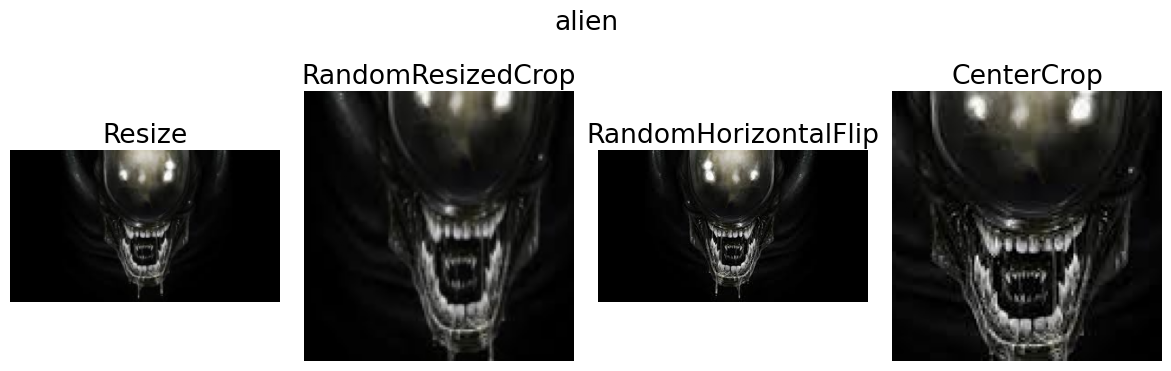

In [53]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import (
    Compose,
    RandomResizedCrop,
    RandomHorizontalFlip,
    ToTensor,
    Resize,
    CenterCrop,
)

# Look at one image from the dataset
preview_data = ImageFolder(os.path.join("/root/.cache/kagglehub/datasets/pmigdal/alien-vs-predator-images/versions/1", "data", "train"))
img, labels = preview_data[10]

# Let's inspect the effect of the various transformers
fig = plt.figure(figsize=(16, 8))

def show_image(img, labels, transforms_list):
    # permute turns (rgb, height, width) into (height, width, rgb)
    if type(transforms_list) is list:
        fig, axis = plt.subplots(1, len(transforms_list), figsize=(12, 4))

        for i, (transformation, name) in enumerate(transforms_list):
            axis[i].imshow(transformation(img).permute(1, 2, 0))
            axis[i].set_title(name)
            fig.suptitle(class_names[labels])
            axis[i].axis("off")
    # else:
        # img = transforms_list(img)
        # fig, axis = plt.subplots(1, len(img), figsize=(12, 4))

        # for i,( image, label) in enumerate(zip(img, labels)):
        #     axis[i].imshow(img.permute(1, 2, 0))
        #     axis[i].set_title(name)
        #     axis[i].xlabel(class_names[labels])
        #     axis[i].axis("off")

    plt.tight_layout()
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################

# transform image with some transformations and show them

transformations = [
    (Compose([Resize(128), ToTensor()]), "Resize"),
    (Compose([RandomResizedCrop(128), ToTensor()]), "RandomResizedCrop"),
    (Compose([RandomHorizontalFlip(), ToTensor()]), "RandomHorizontalFlip"),
    (Compose([CenterCrop(128), ToTensor()]), "CenterCrop",)
]

show_image(img, labels, transformations)
#################################################################################
#                                   THE END                                     #
#################################################################################


Note that the transformations above are random, so if you run the cell multiple times, you will see different results.

### Visualize some training samples

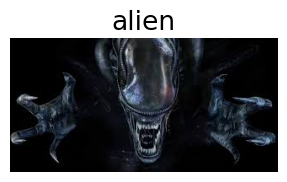

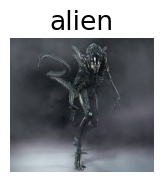

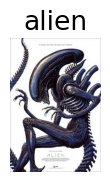

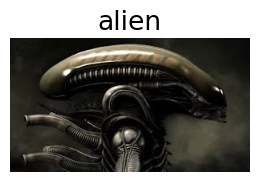

In [54]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# show_image(preview_data[:, 0], preview_data[:, 1])
#################################################################################
#                                   THE END                                     #
#################################################################################
for i, j in enumerate([np.random.randint(0, 100) for _ in range(4)]):
    plt.figure(figsize=(16, 8))
    plt.subplot(4, 1, i+1)
    plt.imshow(preview_data[j][0])
    plt.title(class_names[preview_data[j][1]])
    plt.axis("off")


---

# Loading a pre-trained model

### List of available pre-trained models

`torchvision` includes many pre-trained models. Let's get a list and have a look.

In [55]:
for model in dir(torchvision.models):
    if model.startswith("_"): continue  # Skip private properties
    print(f"- {model}")

- AlexNet
- AlexNet_Weights
- ConvNeXt
- ConvNeXt_Base_Weights
- ConvNeXt_Large_Weights
- ConvNeXt_Small_Weights
- ConvNeXt_Tiny_Weights
- DenseNet
- DenseNet121_Weights
- DenseNet161_Weights
- DenseNet169_Weights
- DenseNet201_Weights
- EfficientNet
- EfficientNet_B0_Weights
- EfficientNet_B1_Weights
- EfficientNet_B2_Weights
- EfficientNet_B3_Weights
- EfficientNet_B4_Weights
- EfficientNet_B5_Weights
- EfficientNet_B6_Weights
- EfficientNet_B7_Weights
- EfficientNet_V2_L_Weights
- EfficientNet_V2_M_Weights
- EfficientNet_V2_S_Weights
- GoogLeNet
- GoogLeNetOutputs
- GoogLeNet_Weights
- Inception3
- InceptionOutputs
- Inception_V3_Weights
- MNASNet
- MNASNet0_5_Weights
- MNASNet0_75_Weights
- MNASNet1_0_Weights
- MNASNet1_3_Weights
- MaxVit
- MaxVit_T_Weights
- MobileNetV2
- MobileNetV3
- MobileNet_V2_Weights
- MobileNet_V3_Large_Weights
- MobileNet_V3_Small_Weights
- RegNet
- RegNet_X_16GF_Weights
- RegNet_X_1_6GF_Weights
- RegNet_X_32GF_Weights
- RegNet_X_3_2GF_Weights
- RegNet_X_4

### We will use the ResNet-18 architecture:
![ResNet-picture](https://github.com/theevann/webconf-pytorch-workshop/blob/master/figures/resnet.png?raw=1)

It's very simple to create a module that has this model with its weights pre-trained for ImageNet.

In [56]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################

# define pre_trained model
from torchvision.models import resnet18, ResNet18_Weights
resnet_model = resnet18(weights=ResNet18_Weights)

#################################################################################
#                                   THE END                                     #
#################################################################################

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### A closer look at the ResNet-18

The last fully connected layer has a 1000 output neurons. It has been trained on ImageNet task which has 1000 image classes.

In [57]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################

# print last layer of model

for name, param in resnet_model.named_children():
    print(name, "-------->", param)

#################################################################################
#                                   THE END                                     #
#################################################################################

conv1 --------> Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
bn1 --------> BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
relu --------> ReLU(inplace=True)
maxpool --------> MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
layer1 --------> Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (co

We would like to perform binary classification (alien/predator). Therefore, we have to replace the last fully-connected layer to suit our needs (two output units).

In [58]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################

# replace last layer with suitable layer
resnet_model.fc = nn.Sequential(
    nn.Linear(512, 256),
    nn.BatchNorm1d(256),
    nn.GELU(),
    nn.Dropout(0.5),
    nn.Linear(256, 1)
)

#################################################################################
#                                   THE END                                     #
#################################################################################

---

# Training just the last layer

### Freeze all the layers except the last fully-connected one

**First way**

In [59]:
from pickle import FALSE
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################

# Freeze all the layers except the last fully-connected one
for param in resnet_model.parameters():
    param.requires_grad = False
for param in resnet_model.fc.parameters():
    param.requires_grad = True
for param in resnet_model.layer4.parameters():
    param.requires_grad = True
#################################################################################
#                                   THE END                                     #
#################################################################################

**Second way**

In [60]:
for name, param in resnet_model.named_parameters():
    print(name, "--->", param.requires_grad)

conv1.weight ---> False
bn1.weight ---> False
bn1.bias ---> False
layer1.0.conv1.weight ---> False
layer1.0.bn1.weight ---> False
layer1.0.bn1.bias ---> False
layer1.0.conv2.weight ---> False
layer1.0.bn2.weight ---> False
layer1.0.bn2.bias ---> False
layer1.1.conv1.weight ---> False
layer1.1.bn1.weight ---> False
layer1.1.bn1.bias ---> False
layer1.1.conv2.weight ---> False
layer1.1.bn2.weight ---> False
layer1.1.bn2.bias ---> False
layer2.0.conv1.weight ---> False
layer2.0.bn1.weight ---> False
layer2.0.bn1.bias ---> False
layer2.0.conv2.weight ---> False
layer2.0.bn2.weight ---> False
layer2.0.bn2.bias ---> False
layer2.0.downsample.0.weight ---> False
layer2.0.downsample.1.weight ---> False
layer2.0.downsample.1.bias ---> False
layer2.1.conv1.weight ---> False
layer2.1.bn1.weight ---> False
layer2.1.bn1.bias ---> False
layer2.1.conv2.weight ---> False
layer2.1.bn2.weight ---> False
layer2.1.bn2.bias ---> False
layer3.0.conv1.weight ---> False
layer3.0.bn1.weight ---> False
layer3.0

In [61]:
######### do not uncomment followings #########

# model_ft.requires_grad_(False)
# model_ft.fc.requires_grad_(True)

**Third way**

A third way could be to pass to the optimiser only the parameters of the last linear layer.  
However, this is not as good as the previous methods, do you see why ?  
Hint: All the gradients are still computed...

### Define the train and accuracy functions

So, now the architecture contains two output units, we can therefore use it to perform binary classification.

The *train* and _accuracy_ function are almost identical to the functions we used when traininig the CNN. This again nicely demonstrates the modularity of PyTorch and its simple interface.

In [62]:
from tqdm.auto import tqdm, trange
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
def train(
    model,
    criterion,
    optimizer,
    train_loader,
    test_loader,
    device,
    num_epochs=3,
    learning_rate=0.1,
    decay_learning_rate=False,
):
    model = model.to(device, non_blocking=True)
    opt = optimizer(model.parameters(), lr=learning_rate)
    loss_func = criterion()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=3, factor=0.5)
    scaler = torch.amp.GradScaler()
    list_train = []
    list_val = []
    for epoch in trange(num_epochs, desc="running one epoch ...", leave=True):
        running_val_loss = 0.0
        running_train_loss = 0.0
        model.train()
        for x_train, y_train in tqdm(train_loader, desc="training ...", leave=False):
            x_train, y_train = x_train.to(device, non_blocking=True), y_train.to(device, non_blocking=True)

            opt.zero_grad(set_to_none=True)
            with torch.amp.autocast(device_type=device.type):
                train_preds = model(x_train).view(-1)
                train_loss = loss_func(train_preds, y_train.float())
            scaler.scale(train_loss).backward()
            scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(opt)
            scaler.update()
            running_train_loss += train_loss.item() * y_train.size(0)

        model.eval()
        with torch.inference_mode():
            for x_val, y_val in tqdm(test_loader, desc="evaluating ...", leave=False):
                x_val, y_val = x_val.to(device, non_blocking=True), y_val.to(device, non_blocking=True)
                with torch.amp.autocast(device_type=device.type):
                    val_logits = model(x_val).view(-1)
                    val_loss = loss_func(val_logits, y_val.float())
                running_val_loss += val_loss.item() * y_val.size(0)
            list_train.append(running_train_loss / len(train_loader.dataset))
            list_val.append(running_val_loss / len(test_loader.dataset))
            print(f"test loss --> {running_val_loss / len(test_loader.dataset)}")
            print(f"train loss --> {running_train_loss / len(train_loader.dataset)}")
            if decay_learning_rate:
                scheduler.step(running_train_loss / len(train_loader.dataset))
                print(scheduler.get_last_lr()[0])
    return list_val, list_train, model

#################################################################################
#                                   THE END                                     #
#################################################################################

In [63]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################

# define accuracy function
import torch.nn.functional as F
def accuracy_def(model, loader, device):
    model.eval()
    corrects = 0
    total = 0

    with torch.inference_mode():
        for x_val, y_val in tqdm(loader, desc="evaluating ...", leave=False):
            x_val, y_val = x_val.to(device), y_val.to(device)
            val_logits = model(x_val).squeeze()
            preds = F.sigmoid(val_logits) >= 0.5
            corrects += (preds == y_val).sum()
            total += y_val.shape[0]
    return (corrects / total).item()
#################################################################################
#                                   THE END                                     #
#################################################################################

### Launch training

In [68]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model.to(device)

list_val, list_train, model = train(
    resnet_model,
    nn.BCEWithLogitsLoss,
    torch.optim.AdamW,
    train_loader,
    test_loader,
    device,
    num_epochs=100,
    learning_rate=0.1,
    decay_learning_rate=True,
)

running one epoch ...:   0%|          | 0/100 [00:00<?, ?it/s]

training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 4.883337097825828
train loss --> 0.19626135681056486
0.1


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 1.0199408388137818
train loss --> 0.07925505637994024
0.1


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.4273753011226654
train loss --> 0.12148701619679621
0.1


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.4950558137893677
train loss --> 0.09450197639769085
0.1


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.8532953044492751
train loss --> 0.10844569291398536
0.1


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.36290329590439796
train loss --> 0.22696531495716496
0.05


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.3047645820333855
train loss --> 0.14107242068522638
0.05


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.1864061553031206
train loss --> 0.02159668331420128
0.05


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.1904732719063759
train loss --> 0.06375367891606043
0.05


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.24763504385948182
train loss --> 0.11820144195416622
0.05


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.30020215749740603
train loss --> 0.009493185152433234
0.05


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.3281142771244049
train loss --> 0.00789970484116685
0.05


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.43105785727500917
train loss --> 0.011535826392972822
0.05


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.24719805717468263
train loss --> 0.05719780679188492
0.05


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.15789502263069152
train loss --> 0.041394686440157875
0.05


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.14701581060886382
train loss --> 0.01465165020946379
0.025


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.12603460550308226
train loss --> 0.04563536743250318
0.025


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.14830565214157104
train loss --> 0.0353739916904553
0.025


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.1483214831352234
train loss --> 0.00938956280172583
0.025


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.20206053137779237
train loss --> 0.0017626639922151241
0.025


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.12776582337915898
train loss --> 0.0015813719953233943
0.025


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.11403328999876976
train loss --> 0.01580176846223485
0.025


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.12347531300038099
train loss --> 0.0050731166039736895
0.025


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.14631004631519318
train loss --> 0.0013117775175511867
0.025


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.18648636728525161
train loss --> 0.007715924421373655
0.025


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.16974361065775156
train loss --> 0.00015932867788919584
0.025


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.08263072982430458
train loss --> 0.04633001170950229
0.025


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.08744610965251923
train loss --> 0.002672107681656868
0.025


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.09929366439580917
train loss --> 0.013133795107757829
0.025


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.20575859993696213
train loss --> 0.013637266840017216
0.0125


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.18139856725931167
train loss --> 0.008668209338631027
0.0125


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.14595346987247468
train loss --> 0.01899053745655915
0.0125


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.13716964930295944
train loss --> 0.007486952025538008
0.0125


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.1343260966986418
train loss --> 0.011770581852222215
0.00625


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.1192856178432703
train loss --> 0.037701517898318125
0.00625


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.11478383496403693
train loss --> 0.00788318966335665
0.00625


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.14546999610494823
train loss --> 0.0059550430098054856
0.00625


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.12287849187850952
train loss --> 0.008442178790096936
0.003125


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.12223306857049465
train loss --> 0.01351257959001463
0.003125


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.12949656888842584
train loss --> 0.0012239559752807805
0.003125


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.13520224086940288
train loss --> 0.0701495021687488
0.003125


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.12122426241636276
train loss --> 0.0029826531111851336
0.0015625


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.12473039656877517
train loss --> 0.0070456975635698115
0.0015625


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.1230767896771431
train loss --> 0.01136959128130277
0.0015625


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.14577488780021666
train loss --> 0.014396991902124942
0.0015625


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.11554755449295044
train loss --> 0.004036327095237048
0.00078125


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.11636169701814651
train loss --> 0.004544552572372697
0.00078125


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.1131192373484373
train loss --> 0.0018358784420280095
0.00078125


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.11482127450406551
train loss --> 0.0023120861582964234
0.00078125


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.11379357606172562
train loss --> 0.024919448254774476
0.000390625


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.11103661432862282
train loss --> 0.001610156895726334
0.000390625


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.11601068116724492
train loss --> 0.0038730183288275353
0.000390625


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.1129197582602501
train loss --> 0.0021737488592664177
0.000390625


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.12913171365857123
train loss --> 0.08869963051492645
0.0001953125


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.11091089323163032
train loss --> 0.0017278374103069881
0.0001953125


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.11677527330815791
train loss --> 0.0011350498744761527
0.0001953125


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.12176742389798165
train loss --> 0.016171547461047625
0.0001953125


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.11405326545238495
train loss --> 0.0028894868706231098
9.765625e-05


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.11586565971374511
train loss --> 0.006512260883148487
9.765625e-05


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.11516937628388405
train loss --> 0.006282509119942543
9.765625e-05


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.12621863633394242
train loss --> 0.002217282207927595
9.765625e-05


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.11717379860579967
train loss --> 0.001165974880130029
4.8828125e-05


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.11770095072686672
train loss --> 0.0009579689508005052
4.8828125e-05


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.10753282770514488
train loss --> 0.0010904151770482818
4.8828125e-05


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.11259135752916336
train loss --> 0.00934845333993623
4.8828125e-05


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.10914845556020737
train loss --> 0.0013629864381115213
2.44140625e-05


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.11227762058377266
train loss --> 0.00191857027302228
2.44140625e-05


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.11111712470650673
train loss --> 0.002006223968979213
2.44140625e-05


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.11243173062801361
train loss --> 0.002787301500947453
2.44140625e-05


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.12102254271507264
train loss --> 0.008867132940733206
1.220703125e-05


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.12622078120708466
train loss --> 0.0014360286373520433
1.220703125e-05


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.11051098987460137
train loss --> 0.0018620041383349258
1.220703125e-05


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.11364280566573143
train loss --> 0.0020880099277943496
1.220703125e-05


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.11809483092278242
train loss --> 0.002551736968716835
6.103515625e-06


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.11205310106277466
train loss --> 0.005355932853547893
6.103515625e-06


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.13703133322298527
train loss --> 0.004601542522142293
6.103515625e-06


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.17773666546214373
train loss --> 0.010802692982995707
6.103515625e-06


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.13421452686190605
train loss --> 0.00792180931171126
3.0517578125e-06


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.11120024800300599
train loss --> 0.0015729550187841214
3.0517578125e-06


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.11329903200268746
train loss --> 0.00062371460028192
3.0517578125e-06


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.11286497443914413
train loss --> 0.002251515973942317
3.0517578125e-06


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.10914769984781741
train loss --> 0.007919277355802647
1.52587890625e-06


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.12454906668514014
train loss --> 0.003921362339908637
1.52587890625e-06


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.10967498511075974
train loss --> 0.0026005113543889104
1.52587890625e-06


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.10972887247800828
train loss --> 0.0015565235578634182
1.52587890625e-06


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.1516801806911826
train loss --> 0.06038101852524412
7.62939453125e-07


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.1276760184019804
train loss --> 0.0030052613334854966
7.62939453125e-07


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.114612727612257
train loss --> 0.0005718209530653411
7.62939453125e-07


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.12365938048809767
train loss --> 0.002612069201398113
7.62939453125e-07


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.11806352317333221
train loss --> 0.001228880915680168
3.814697265625e-07


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.12069581136107445
train loss --> 0.024940845180723564
3.814697265625e-07


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.11836846441030502
train loss --> 0.0015849338320203603
3.814697265625e-07


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.11635600417852401
train loss --> 0.0006551070887208259
3.814697265625e-07


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.11393311575055122
train loss --> 0.0014028365559754685
1.9073486328125e-07


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.11758957654237748
train loss --> 0.0046555550366956435
1.9073486328125e-07


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.11491182148456573
train loss --> 0.00031099519838378504
1.9073486328125e-07


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.11724111244082451
train loss --> 0.0031737308525391843
1.9073486328125e-07


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.11468544647097588
train loss --> 0.0030107249818298776
9.5367431640625e-08


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.12297851264476777
train loss --> 0.002575790303967617
9.5367431640625e-08


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.12643543586134912
train loss --> 0.0005448600327575855
9.5367431640625e-08


### Inspecting the model's predictions

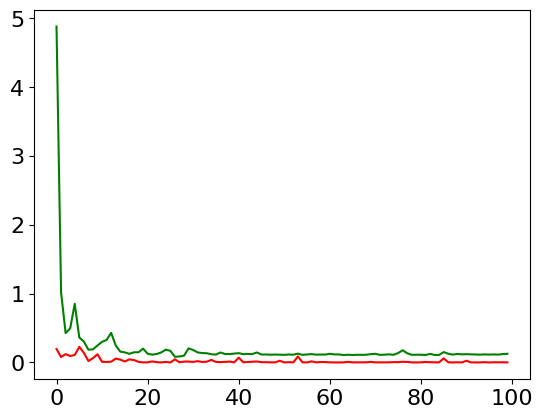

In [69]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# show some predictions
import matplotlib.pyplot as plt
plt.plot(list_train, c="red")
plt.plot(list_val, c="green")

#################################################################################
#                                   THE END                                     #
#################################################################################

In [70]:
accuracy_def(model, test_loader, device)

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

0.9449999928474426